# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [ ]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if - len(self.queue) <= pop_ix < len(self.queue) :
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
        

            
        return pop_val

In [ ]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [ ]:
service = InService()

service.full()

False

In [ ]:
class QS():
    
    def __init__(self, arval_intensity, srv_time, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_intensity = arval_intensity
        self.srv_time = srv_time
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_time)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_intensity(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        
        #Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        
        #Initializing arrival queue
        #wline.queue = list(tops.loc[0:1].index)
        wline.queue = list(tops.loc[0:self.queue_z].index)
        
        
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1
    
        while buffer_ix < self.test_z:
            #print("queue",wline.queue)
            #print("inservice", inservice.server)

            in_queue = (tops.loc[0:buffer_ix - 1, 't_arval_srv'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
            if self.queue_z is None or in_queue < self.queue_z:
                _next = wline.pop()
                if _next is not None: #Waiting line is not empty 
                    #print(f"_next : {_next}")
                    #print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                    #Update server arrival time as if no waiting was needed
                    tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']
                    
                    #Find next available server
                    #dept_ag is the agent with the smallest departure time
                    srv_ix, dept_ag = inservice.leaving(tops)
                    
                        
                    #Fill available server with corresponding next agent in waiting line
                    inservice.server[srv_ix] = _next 
                        
                    #Ici on fait attendre le _next, sois celui qui doit rentrer dans le serveur(), tant que celui dans le serveur n'est pas parti
                    if dept_ag is not None :
                        if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys'] : 
                            #Update server arrival time in ca   se arrival is before system departure
                            tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']
                            
                            
                    #Update system departure time
                    tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
            
            #print("in_system",in_system )
                           
            if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            elif buffer_ix + self.queue_z < self.test_z:
                wline.queue.append(buffer_ix + self.queue_z)
                    
            buffer_ix += 1
                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z
        #print(tops)
        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
            
        #print(tops)
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)

        return process, stats
    
    
    def maxtime(self):
        return self.tops['t_waiting'].max()
        

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

Les deux systemes à analyser sont:

M/M/1/k
   -  M: Processus de poisson
   -  1: 1 serveur
   -  k: capacité max de la file d'attente
   -  FIFO (Par defaut) : premier entré, premier sorti

M/M/1/k/LIFO
   - M: Processus de poisson
   - 1: 1 serveur
   - k: capacité max de la file d'attente
   - LIFO : Discipline de service LIFO  : dernier entré, premier sorti 

Ici on génere les arguments:

In [ ]:
rng = np.random.default_rng(seed=42)

In [ ]:
srv_nb = 1
arval_intensity = lambda size : rng.exponential(1./40, size=size)
srv_time = lambda :  rng.exponential(1./4.)
fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

Ci dessous on trouve la simulation des deux systemes:

In [ ]:
mm1_fifo = QS(arval_intensity, srv_time, srv_nb, queue_size=10, test_size=100, policy=fifo_policy)
mm1_lifo = QS(arval_intensity, srv_time, srv_nb, queue_size=10, test_size=100, policy=lifo_policy)

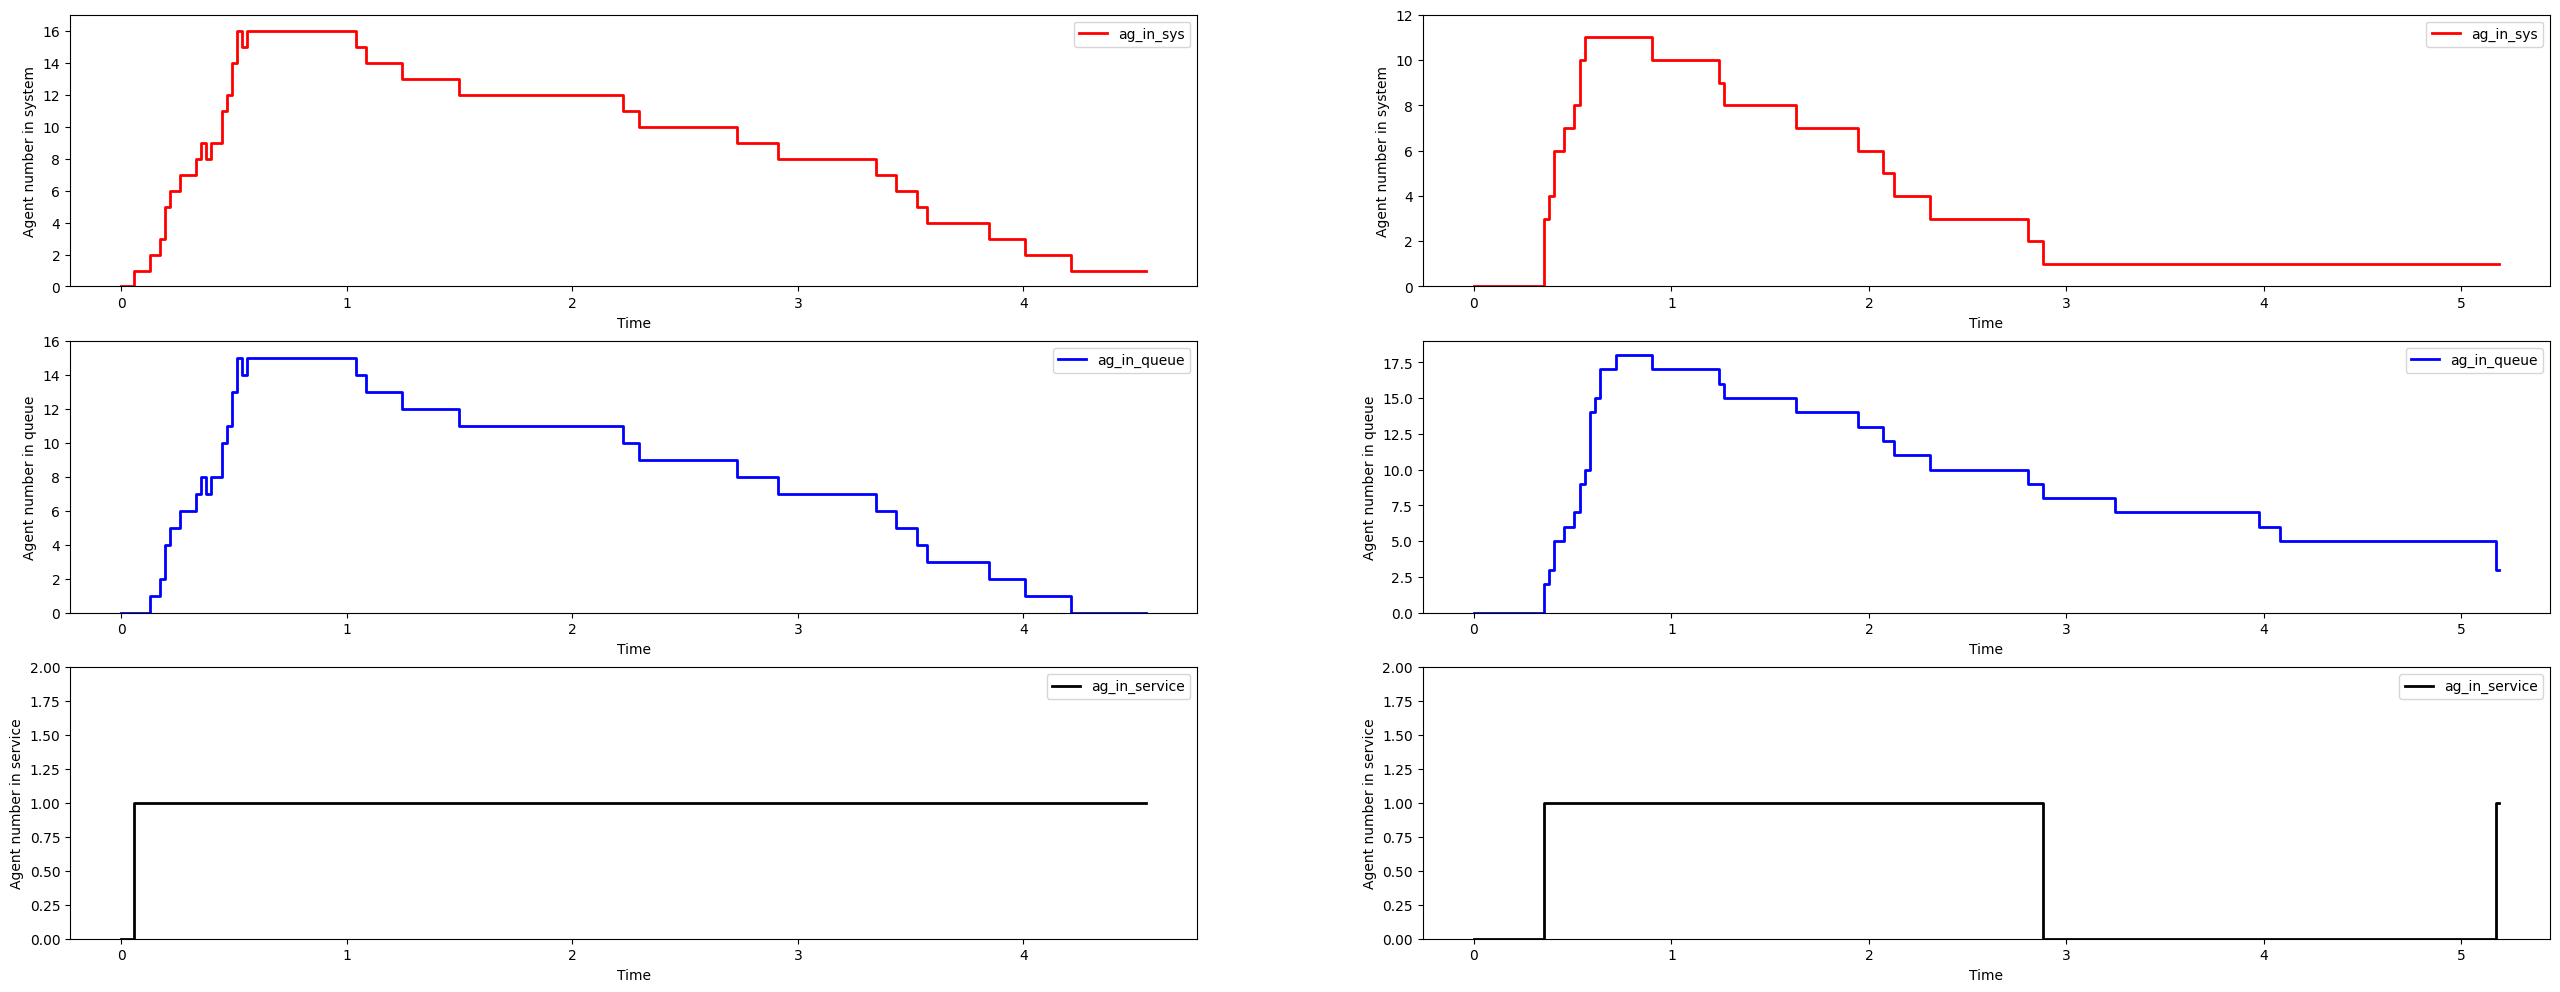

In [ ]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

mm1_fifo.run()
mm1_lifo.run()

mm1_fifo.posttreat()
mm1_lifo.posttreat()

mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()


fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench[counts[i]]+1)])

    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench[counts[i]]+1)])

In [ ]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,1.914923,0.226962
mean_waiting_time,1.701409,0.197265
mean_service_time,0.213514,0.029697
waiting_proportion,0.952381,0.127907
blocked_proportion,0.79,0.14
servers_max_usage,0.98995,0.492462


**Réponse Q1.1**

*CORRECTION D'ERREUR:*

Pour répondre à la question 1, on a observé qu'il fallait modifier le code donnée. 

Tout d'abord, le comportement de la file d'attente était pas celui voulu. En effet, on a remarqué qu'en affichant la liste d'attente à chaque itteration de la methode *run*, cette même liste d'attente ne se remplissait que d'un élément à la fois. 

Dans la classe Wline, dans la méthode pop(), la condition pour vérifier l'index pop_ix a été modifiée. Avant, la condition était ``` if - len(self.queue) < pop_ix < len(self.queue) ```, ce qui signifie que l'index pop_ix devait être strictement inférieur à la longueur de la file. Cependant, cette condition excluait le dernier élément de la file. La condition a été modifiée pour ``` if - len(self.queue) <= pop_ix < len(self.queue) ```, ce qui permet de prendre en compte également le dernier élément de la file.

Ces changements ont été apportés pour corriger un possible bogue dans la méthode pop() de la classe Wline. La condition précédente excluait le dernier élément de la file lors de la vérification de l'index pop_ix. En modifiant la condition, le dernier élément peut également être pris en compte lors de la suppression de l'élément de la file.

les changements effectués dans la classe QS sont les suivants :

Dans la méthode run(), la ligne ``` wline.queue = list(tops.loc[0:1].index) ``` a été modifiée en ``` wline.queue = list(tops.loc[0:self.queue_z].index) ```. La modification permet d'initialiser la file d'attente avec un nombre personnalisé d'agents (déterminé par self.queue_z) au lieu d'utiliser un intervalle statique de 2 agents (0 à 1). Cela permet de contrôler la taille de la file d'attente lors de l'initialisation.

Dans la méthode run(), la variable in_system a été ajoutée pour compter le nombre d'agents présents dans le système avant de décider d'ajouter un nouvel agent à la file d'attente. Cela garantit que la taille de la file d'attente ne dépasse pas self.queue_z + self.inservice.nb, où self.inservice.nb représente le nombre de serveurs. Si la file d'attente atteint cette taille, les agents suivants sont marqués comme bloqués (tops.loc[buffer_ix, 't_depart_sys'] = -1). Cela limite la taille de la file d'attente et empêche la surcharge du système.

La méthode maxtime() a été ajoutée pour calculer le temps d'attente maximal (t_waiting) parmi tous les agents présents dans le système. Cette méthode renvoie simplement la valeur maximale de la colonne 't_waiting' du DataFrame tops.

Ces changements semblent viser à améliorer la flexibilité et le contrôle sur les paramètres du modèle de file d'attente, notamment en permettant de spécifier une taille de file d'attente personnalisée et en fournissant une méthode pour obtenir le temps d'attente maximal.

*NOUVELLES METRIQUES:* 

Aprés cette partie de correction d'erreur, on à décider de rajouter des éléments de tests afin de mieux répondre à la question. 

Ces nouveaux indicateur sont:
- Le **taux d'occupation du server**, pour voir l'efficacité de chaqu'un des systémes
- Le **temps maximale d'attente**, afin d'observer si LIFO et FIFO ne faisaient pas attendre une seule personne plus longtemps que les autres. 

Le code ci dessous permet de completer les graphiques donnés au dessus:

<function matplotlib.pyplot.show(close=None, block=None)>

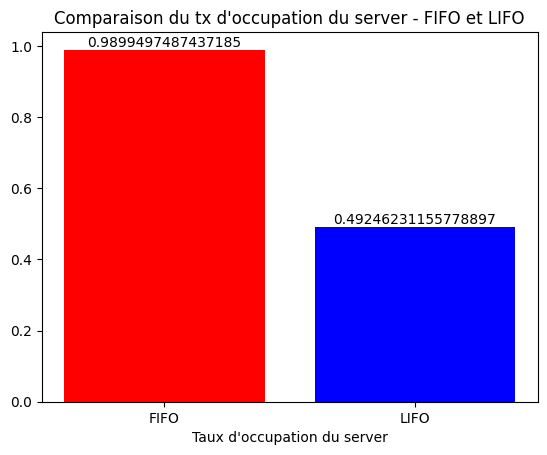

In [ ]:
#----------------------------
# 1 - Taux d'occupation du server:
#----------------------------

fifo_server_occupation = mm1_fifo_stats.loc['servers_max_usage'][0]
lifo_server_occupation = mm1_lifo_stats.loc['servers_max_usage'][0]

labels = ['FIFO', 'LIFO']

values = [fifo_server_occupation, lifo_server_occupation]
colors = ['red', 'blue']

plt.bar(labels, values, color=colors)

for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.title("Comparaison du tx d'occupation du server - FIFO et LIFO")

plt.xlabel("file d'attente")
plt.xlabel("Taux d'occupation du server")

plt.show

In [ ]:
#----------------------------
# 2 - Tps max d'attente :
#----------------------------

print("max fifo:", mm1_fifo.maxtime())
print("max lifo:", mm1_lifo.maxtime())

max fifo: 3.6673092303485957
max lifo: 4.542418339028415


*CONCLUSION*

On en conclu que en analysant toutes les métriques, les simulation FIFO et LIFO sont différentes: 
- FIFO a une **occupation du server** superieur. La FIFO semble être plus optimisé!
- La **moyenne de séjour** est significativement plus importante pour la file en LIFO que celle en FIFO
- Le **temps moyen d'attente** est également supérieur en LIFO qu'en FIFO

En moyenne, une FIFO semble être meilleure qu'une LIFO. Mais en regardant en détail grace aux indicateurs, on observe que cette amélioration se fait au détriment des premiéres personnes à entrer dans la file d'attente qui auront un temps d'attente plus long.

**Réponse Q1.2**


On a mis la variable `queue_size` à 0 afin d'analyser les systems suivants:
-   M/M/1
-   M/M/1/LIFO

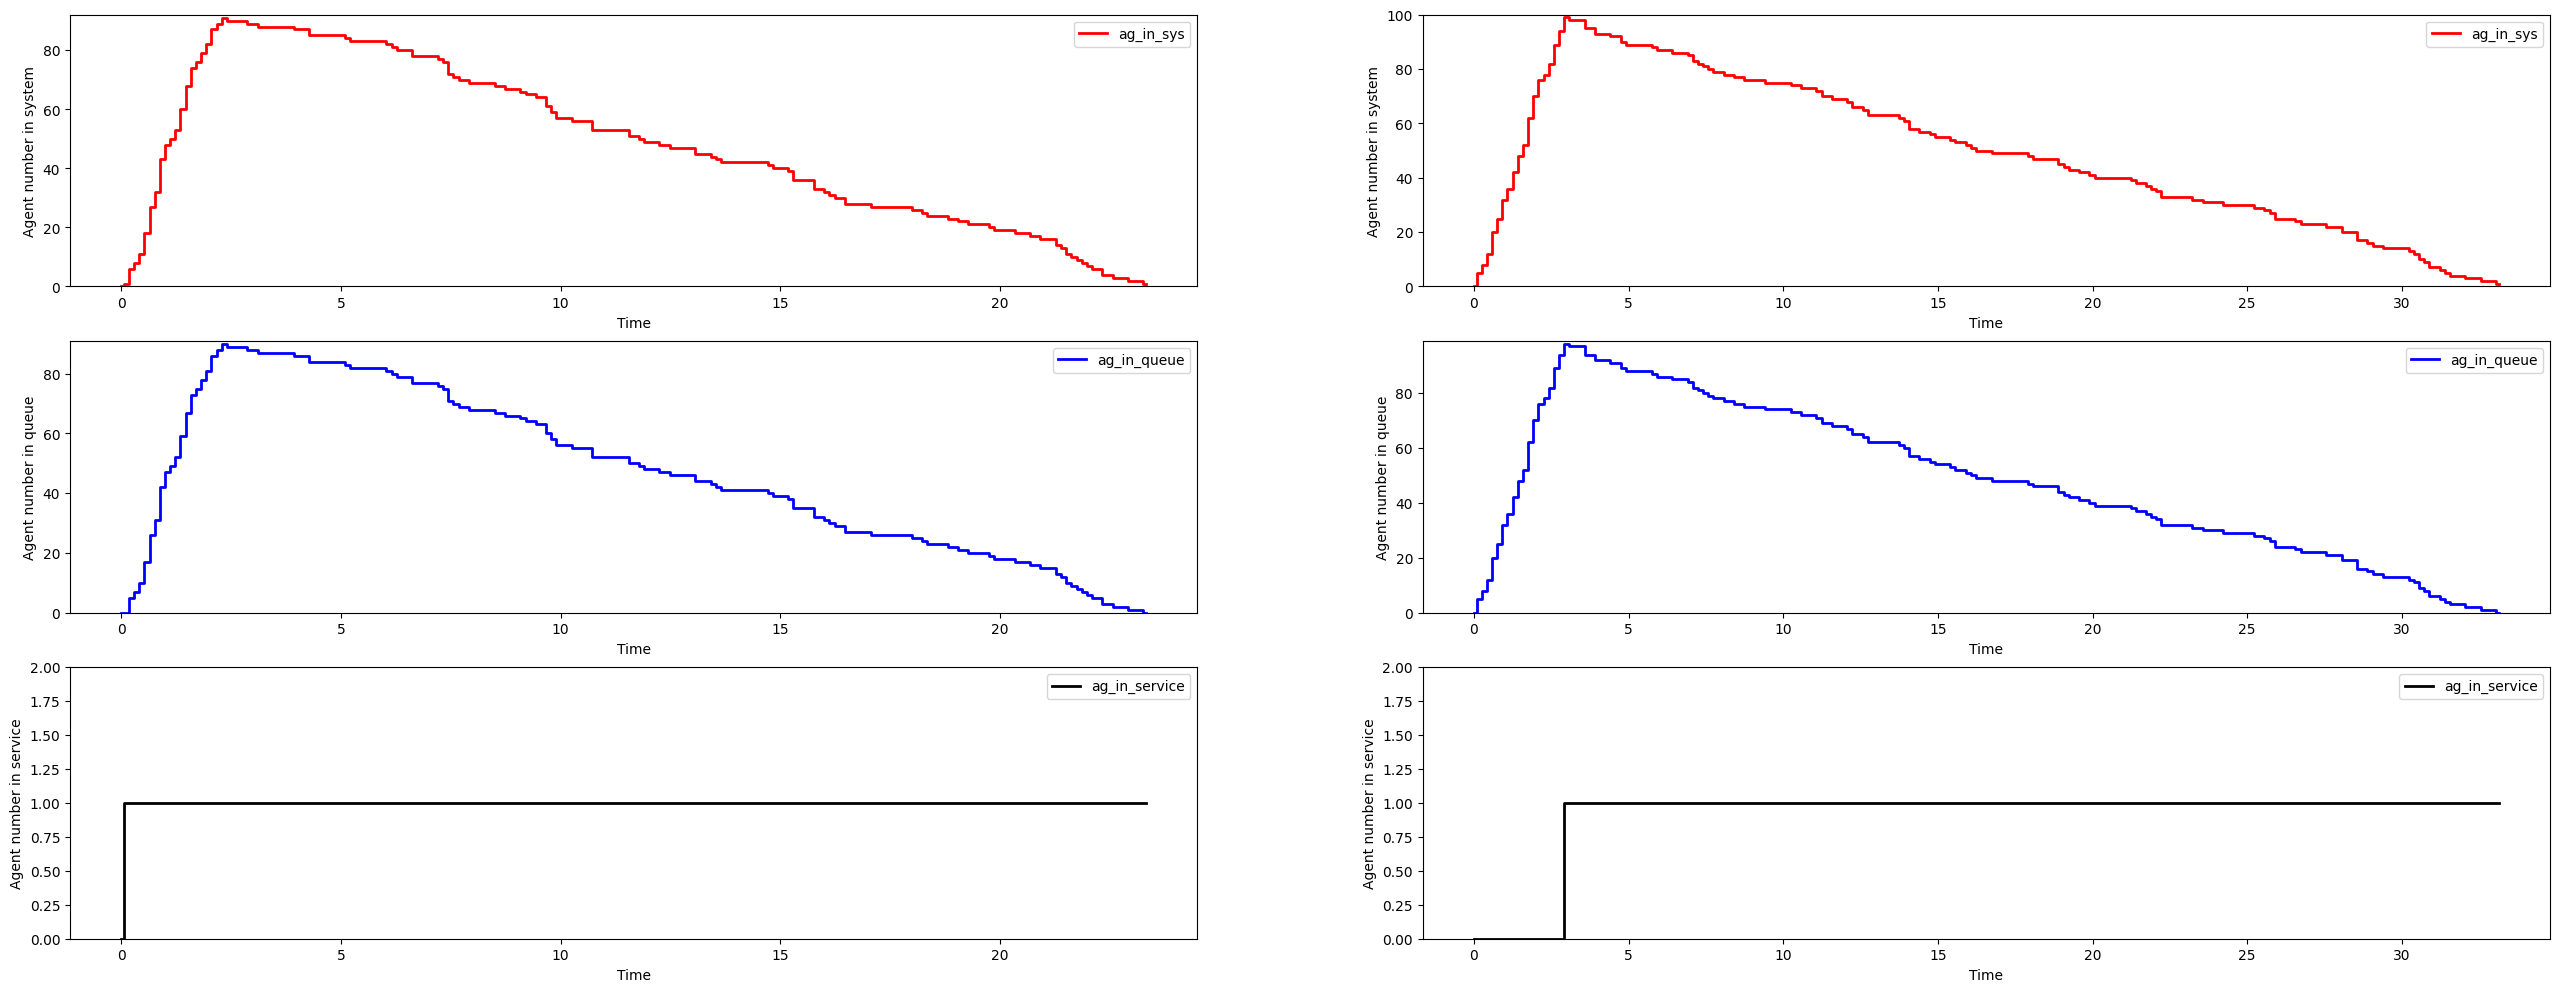

In [ ]:
mm1_fifo = QS(arval_intensity, srv_time, srv_nb, queue_size=0, test_size=100, policy=fifo_policy)
mm1_lifo = QS(arval_intensity, srv_time, srv_nb, queue_size=0, test_size=100, policy=lifo_policy)

mm1_fifo.pretreat()
mm1_lifo.pretreat()

mm1_fifo.run()
mm1_lifo.run()

mm1_fifo.posttreat()
mm1_lifo.posttreat()

mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()


fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench[counts[i]]+1)])

    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench[counts[i]]+1)])

Nous obtenons le même résultat que précédemment, c'est-à-dire que la FIFO est plus optimale en moyenne que la LIFO. Cependant, cela se fait toujours au détriment de quelques utilisateurs.

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_1$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 3$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.

### Résumé des variables utilisées dans le contexte donné :

1. $s_1, s_2, s_3, s_4, s_5$ : Serveurs disponibles pour le service. Il y a 5 serveurs au total.

2. $f_1, f_2, f_3$ : Files d'arrivées FIFO. Il y a 3 files d'arrivées.

3. $z_1, z_2, z_3$ : Tailles respectives des files d'arrivées $f_1, f_2, f_3$.

4. $\mu_1, \mu_2, \mu_3, \mu_4, \mu_5$ : Paramètres des lois exponentielles pour les temps de service des serveurs $s_1, s_2, s_3, s_4, s_5$. Ces paramètres déterminent les taux de service des serveurs.

5. $\lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5$ : Intensités d'arrivée des sous-populations $A_1, A_2, A_3, A_4, A_5$. Ces intensités d'arrivée déterminent les taux d'arrivée des agents dans chaque sous-population.

6. $a_1, a_2, a_3, a_4, a_5$ : Tailles respectives des sous-populations $A_1, A_2, A_3, A_4, A_5$. Ces tailles indiquent le nombre d'agents dans chaque sous-population.

**Réponse Q2.1**

La classe MQS1 est une extension de la classe QS qui a été fournie initialement. La classe QS représente un système de file d'attente simple avec une seule file d'arrivée et plusieurs serveurs, tandis que la classe MQS1 étend cette fonctionnalité en permettant plusieurs files d'arrivées et en prenant en compte plusieurs sous-populations.

Voici les principales différences:

Gestion des files d'arrivées : Dans la classe QS, il n'y a qu'une seule file d'arrivée représentée par la liste queue. En revanche, dans la classe MQS1, nous avons introduit la possibilité d'avoir plusieurs files d'arrivées avec différentes intensités d'arrivée pour chaque sous-population. nous avons utilisé la liste wline pour représenter les files d'attente.

Gestion des sous-populations : La classe QS ne prend pas en compte les sous-populations. En revanche, dans la classe MQS1, nous avons ajouté la prise en compte des sous-populations en utilisant la colonne subpop dans le dataframe tops. Cela vous permet de différencier les agents en fonction de leur sous-population lors du traitement et du calcul des statistiques.

Politique de file d'attente : Dans la classe QS, la politique de file d'attente est spécifiée lors de l'initialisation de la classe en utilisant la fonction policy. Cependant, dans la classe MQS1, nous avons adapté la politique de file d'attente pour chaque file d'attente spécifique à chaque sous-population. nous avons utilisé la liste wline pour stocker les files d'attente et avez spécifié la politique pour chaque file d'attente lors de son initialisation.

Statistiques et chronologie : Dans la classe QS, les statistiques et la chronologie sont calculées en fonction du nombre total d'agents et du nombre de serveurs. Dans la classe MQS1, nous avons adapté les statistiques et la chronologie pour prendre en compte les sous-populations. nous avons ajouté la colonne subpop dans le dataframe tops et avez modifié les calculs de statistiques et de chronologie pour tenir compte des différentes sous-populations.

En résumé, la classe MQS1 que nous avous créée pour la question 1 étend la classe QS en ajoutant la gestion de plusieurs files d'arrivées, la prise en compte de plusieurs sous-populations et l'adaptation des politiques de file d'attente et des calculs de statistiques en conséquence. Cela permet de modéliser et de simuler un système de file d'attente plus complexe qui répond aux besoins de services de différentes sous-populations.

In [ ]:
class MQS1:
    def __init__(self, arval_intensity, srv_time, rng, test_size, queue_size=None, policy=lambda x: 0, len_test_size=1):
        """
        Initialise une file d'attente multi-serveurs avec plusieurs files d'arrivées.

        Paramètres :
        - arval_intensity : liste des distributions des temps d'arrivée pour chaque sous-population
        - srv_time : liste des distributions des temps de service pour chaque serveur
        - rng : générateur de nombres aléatoires
        - queue_size : liste optionnelle des tailles des files d'attente pour chaque sous-population
        - policy : fonction optionnelle de politique de file d'attente
        - test_size : liste optionnelle des tailles des tests pour chaque sous-population
        - len_test_size : nombre de tests

        """
        self.nb_pop = len(test_size)

        self.srv_coef = srv_time
        self.arval_coef = arval_intensity

        self.arval_intensity = []
        self.srv_time = []
        for i in range(self.nb_pop):
            self.srv_time.append(lambda: rng.exponential(self.srv_coef[i]))  # Distribution des temps de service
            self.arval_intensity.append(lambda size: rng.exponential(self.arval_coef[i], size=size))  # Distribution des temps d'arrivée

        self.srv_z = len(self.srv_time)

        self.queue_z = queue_size if queue_size else [test_size[i] // self.nb_pop for i in range(self.nb_pop)]  # Tailles des files d'attente
        self.total_queue_z = sum(self.queue_z)
        self.nb_queue = len(self.queue_z)
        self.test_size = test_size
        self.total_size = sum(test_size)

        self.wline = []
        for i in range(self.nb_queue):
            self.wline.append(Wline(size=self.queue_z[i], policy=policy))  # Files d'attente

        self.inservice = InService(nb=self.srv_z, dist=self.srv_time)  # Agents en service

        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys', 'subpop']
        self.tops = pd.DataFrame(np.empty((self.total_size, 4), dtype=object), columns=column_names)  # Données des agents

    def pretreat(self):
        """
        Prépare les temps d'arrivée des agents en générant les temps interarrivées et en les triant.
        """
        tops = self.tops
        t_interarvals = []

        for i in range(self.nb_pop):
            sub_interarvals = self.arval_intensity[i](size=self.test_size[i])
            interarvals_ = [(sub_interarvals[j - 1] + sub_interarvals[j], i) for j in range(1, self.test_size[i])]
            interarvals_.insert(0, (sub_interarvals[0], i))
            t_interarvals.extend(interarvals_)

        t_interarvals.sort()

        for agent, (t_arval, subpop) in enumerate(t_interarvals):
            tops.loc[agent, 't_arval_queue'] = t_arval
            tops.loc[agent, 'subpop'] = subpop

    def run(self):
        """
        Simule le fonctionnement du système de file d'attente.

        """
        wline = self.wline
        inservice = self.inservice
        
        tops = self.tops

        buffer_ix = 1

        for i in range(0, self.nb_queue):
            wline[i].queue = []
            for j in range(0, self.queue_z[i]):
                wline[i].queue.append(buffer_ix)

        while buffer_ix < self.total_size:

            #for i in range(0, self.nb_queue):
            #    print("queue:",i, wline[i].queue)
            #print("server:", inservice.server)

            in_queue = (tops.loc[0:buffer_ix - 1, 't_arval_srv'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
            if self.queue_z is None or in_queue < self.total_queue_z:
                _next = wline[buffer_ix % 3].pop()
                if _next is not None:

                    tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                    srv_ix = tops.loc[_next, 'subpop']
                    dept_ag = inservice.server[srv_ix]

                    inservice.server[srv_ix] = _next

                    if dept_ag is not None:
                        if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                            tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                    tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + inservice.dist[srv_ix]()

            in_system = (tops.loc[0:buffer_ix - 1, 't_depart_sys'] > tops.loc[buffer_ix, 't_arval_queue']).sum()
            #print("in_system",  in_system)
            if self.queue_z is not None and in_system >= self.total_queue_z + self.inservice.nb:
                tops.loc[buffer_ix, 't_depart_sys'] = -1
            elif buffer_ix + self.total_queue_z < self.total_size:
                wline[(buffer_ix + self.total_queue_z) % 3].queue.append(buffer_ix + self.total_queue_z)

            buffer_ix += 1

    def posttreat(self):
        """
        Effectue un post-traitement après la simulation.

        """
        tops = self.tops

        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops['t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0

    def timeline(self, t_delation=2):
        """
        Génère une chronologie du système de file d'attente.

        Paramètres :
        - t_delation : facteur de dilatation du temps pour la chronologie

        Retourne :
        - process : dataframe de la chronologie
        - stats : dataframe des statistiques

        """
        tops = self.tops
        total_size = self.total_size

        t_range = np.linspace(0., tops['t_depart_sys'].max(), int(t_delation * total_size))
        process = pd.DataFrame(np.empty((len(t_range), 4), dtype=object), index=t_range,
                               columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'subpop'])

        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((tops['t_arval_queue'] <= t) & (tops['t_depart_sys'] > t)).sum()
            process.loc[t, 'ag_in_queue'] = ((tops['t_arval_queue'] <= t) & (tops['t_arval_srv'] > t)).sum()
            process.loc[t, 'ag_in_service'] = ((tops['t_arval_srv'] < t) & (tops['t_depart_sys'] > t)).sum()

        stats = pd.DataFrame(index=['mean_sojourn_time', 'mean_waiting_time', 'max_waiting_time', 'mean_service_time',
                                    'waiting_proportion', 'blocked_proportion', 'servers_max_usage'], columns=['run value'])
        stats.loc['mean_sojourn_time'] = tops.loc[~tops['blocked'], 't_sojourn'].mean()
        stats.loc['mean_waiting_time'] = tops.loc[~tops['blocked'], 't_waiting'].mean()
        stats.loc['max_waiting_time'] = tops['t_waiting'].max()
        stats.loc['mean_service_time'] = tops.loc[~tops['blocked'], 't_service'].mean()
        stats.loc['waiting_proportion'] = tops.loc[~tops['blocked'], 'waited'].mean()
        stats.loc['blocked_proportion'] = tops['blocked'].mean()
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.srv_z).mean()
        return process, stats

In [ ]:
def run_graph(arval_intensity, srv_time, rng, q_size, test_size):
   
    mm1_fifo = MQS1(arval_intensity, srv_time, rng, queue_size=q_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = MQS1(arval_intensity, srv_time, rng, queue_size=q_size, test_size=test_size, policy=lifo_policy)
    mm1_fifo.pretreat()
    mm1_lifo.pretreat()
    mm1_fifo.run()
    mm1_lifo.run()
    mm1_fifo.posttreat()
    mm1_lifo.posttreat()
    mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
    mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

    mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

    fig, axes = plt.subplots(3, 2, figsize=(32, 12))
    counts = ['ag_in_sys','ag_in_queue','ag_in_service']
    labels = ['system', 'queue', 'service']
    colors = ['red', 'blue', 'black']

    for i in range(3):
        mm1_fifo_bench.plot(y= counts[i], 
                    use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                    xlabel='Time', ylim=[0,max(mm1_fifo_bench[counts[i]]+1)])
        
        mm1_lifo_bench.plot(y= counts[i], 
                    use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                     xlabel='Time', ylim=[0,max(mm1_lifo_bench[counts[i]]+1)])
                    
    print(mm1_fifo_stats)



                   run value
mean_sojourn_time    1.56028
mean_waiting_time   1.410378
max_waiting_time    4.959729
mean_service_time   0.149902
waiting_proportion     0.136
blocked_proportion       0.0
servers_max_usage        0.0


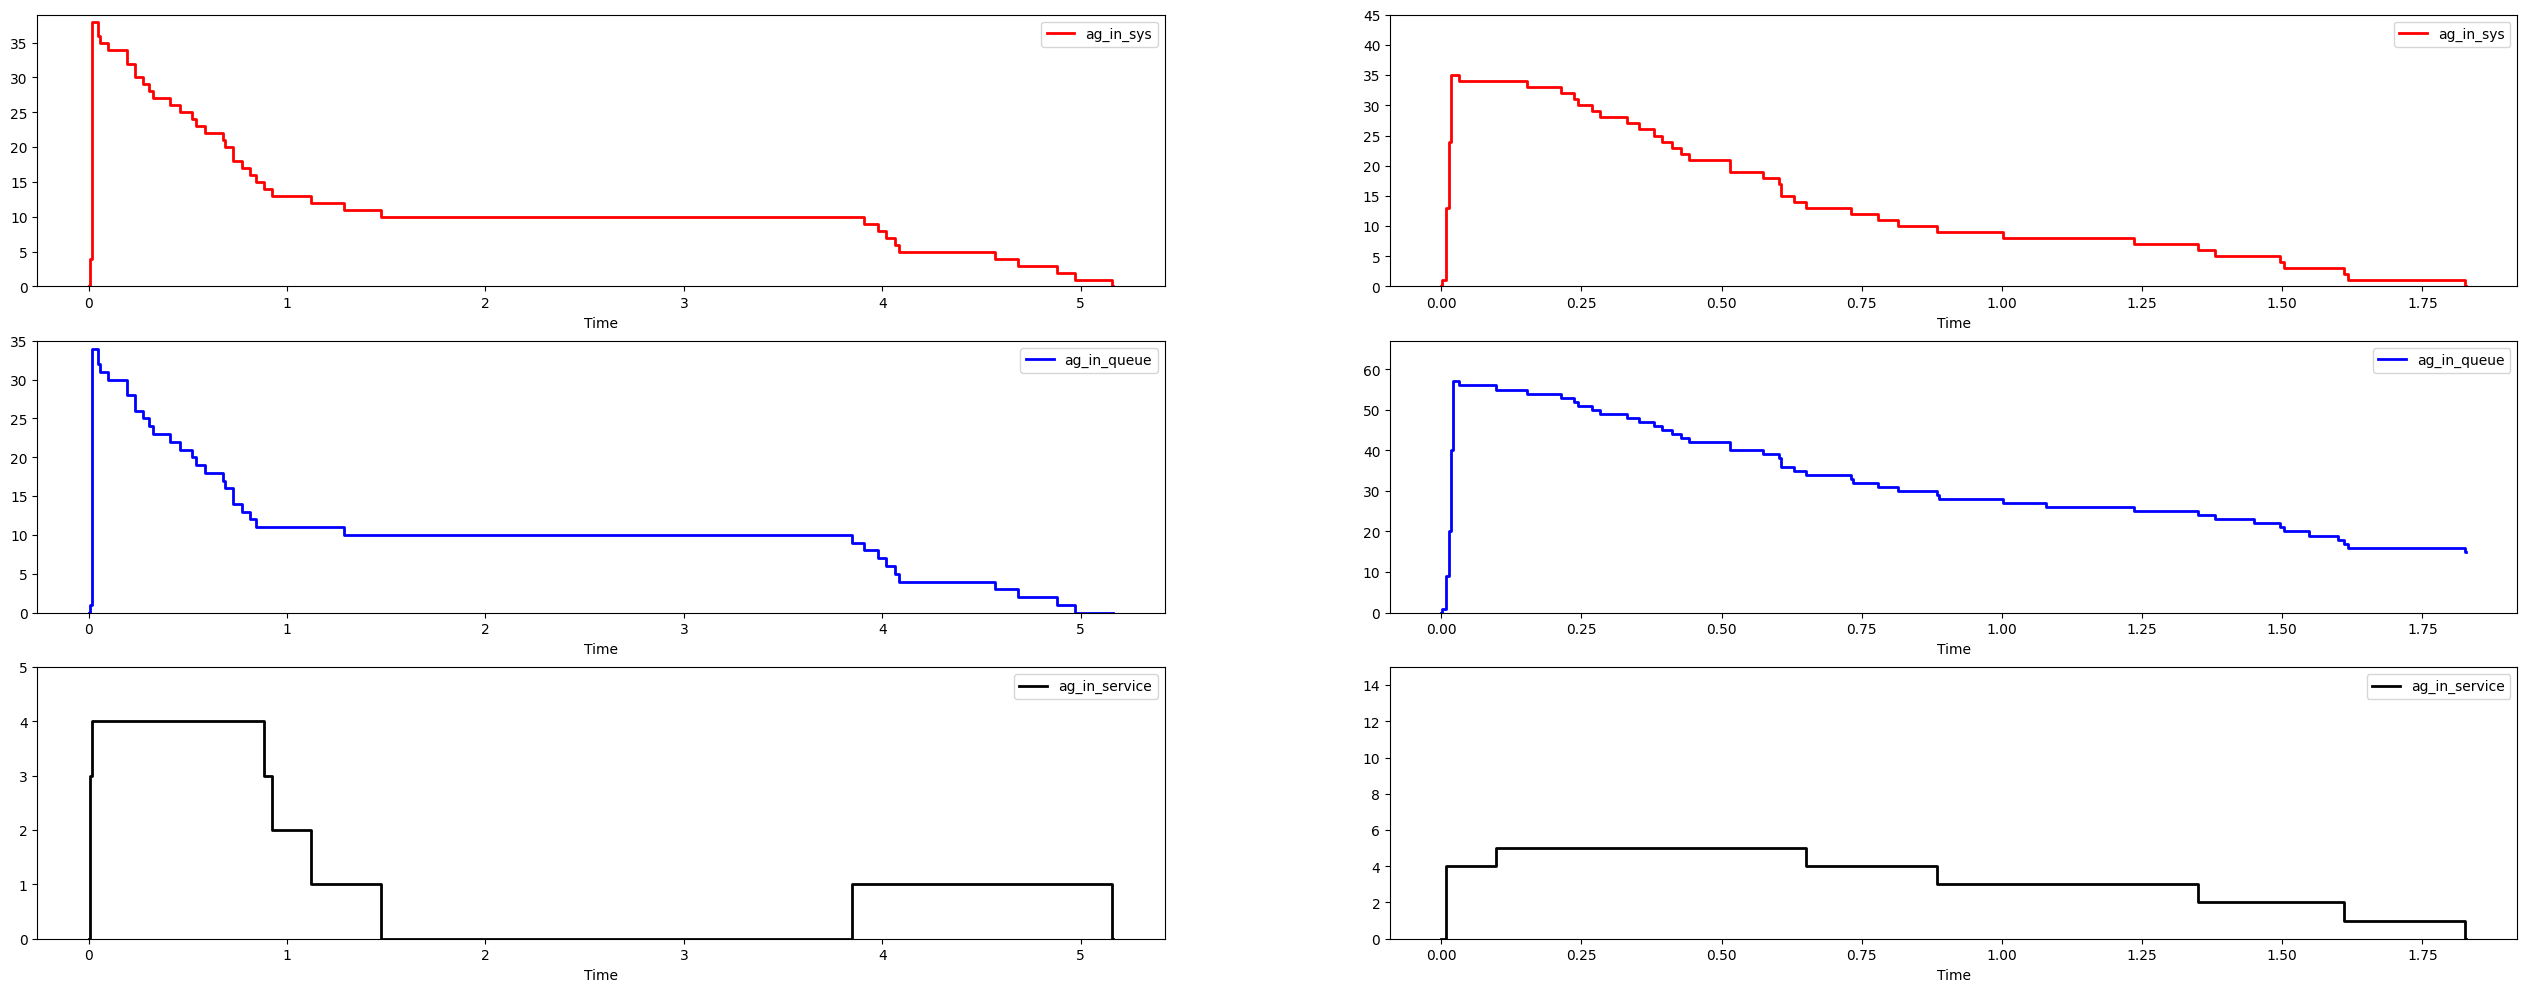

In [ ]:
rng = np.random.default_rng(seed=42)

test_size = [50,50,50,50,50]
q_size = [10,10,10]

srv_time = [1./10., 1./8., 1./7., 1./6., 1./5.]
arval_intensity = [1./100., 1./80., 1./60., 1./40., 1./20.]

run_graph(arval_intensity, srv_time, rng, q_size, test_size)

**Réponse Q2.2**

Pour comparer trois architectures possibles pour répondre aux besoins de services, nous allons simuler les trois architectures et évaluer leurs performances en fonction de certaines métriques clés. Les métriques que nous allons considérer sont les suivantes :

- Temps moyen de séjour : il s'agit du temps moyen qu'un agent passe dans le système, y compris le temps d'attente et le temps de service.
- Temps moyen d'attente : il s'agit du temps moyen qu'un agent passe en attente avant d'être servi.
- Proportion d'agents bloqués : il s'agit de la proportion d'agents qui ne peuvent pas être servis en raison de la saturation du système.
- Utilisation maximale des serveurs : il s'agit de la proportion de temps où tous les serveurs sont occupés.

                   run value
mean_sojourn_time   1.812176
mean_waiting_time   1.623468
max_waiting_time    6.509158
mean_service_time   0.188708
waiting_proportion  0.091429
blocked_proportion       0.0
servers_max_usage        0.0


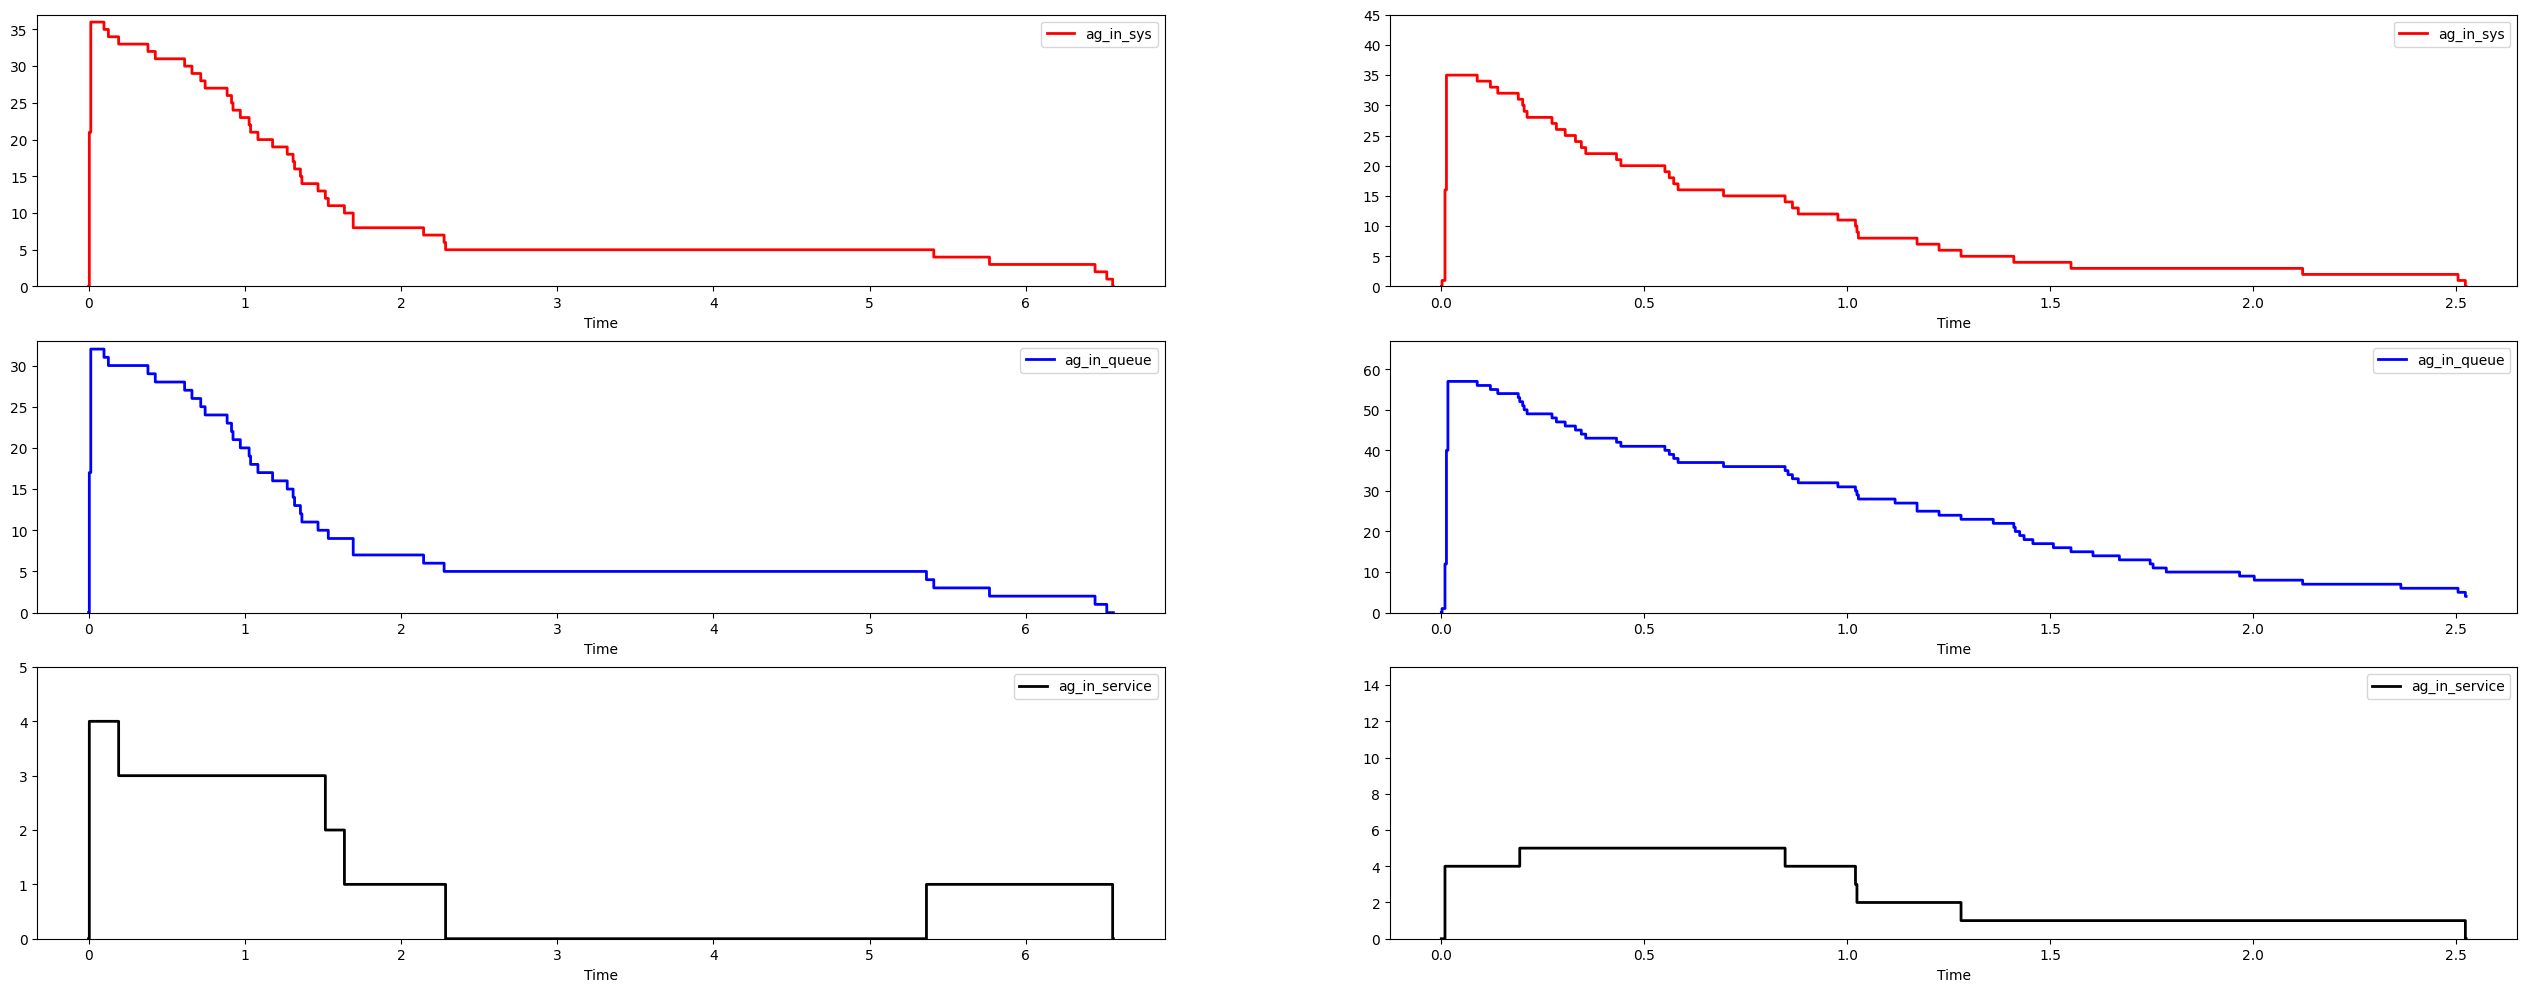

In [ ]:
rng1 = np.random.default_rng(seed=42)


test_size = [50,60,70,80,90]
q_size = [10,10,10]
srv_time = [1./8., 1./7., 1./6., 1./5., 1./4.]
arval_intensity = [1./80., 1./70., 1./60., 1./20., 1./10.]

run_graph(arval_intensity, srv_time, rng, q_size, test_size)

                   run value
mean_sojourn_time   2.120966
mean_waiting_time   1.928058
max_waiting_time    6.271984
mean_service_time   0.192909
waiting_proportion       0.1
blocked_proportion       0.0
servers_max_usage        0.0


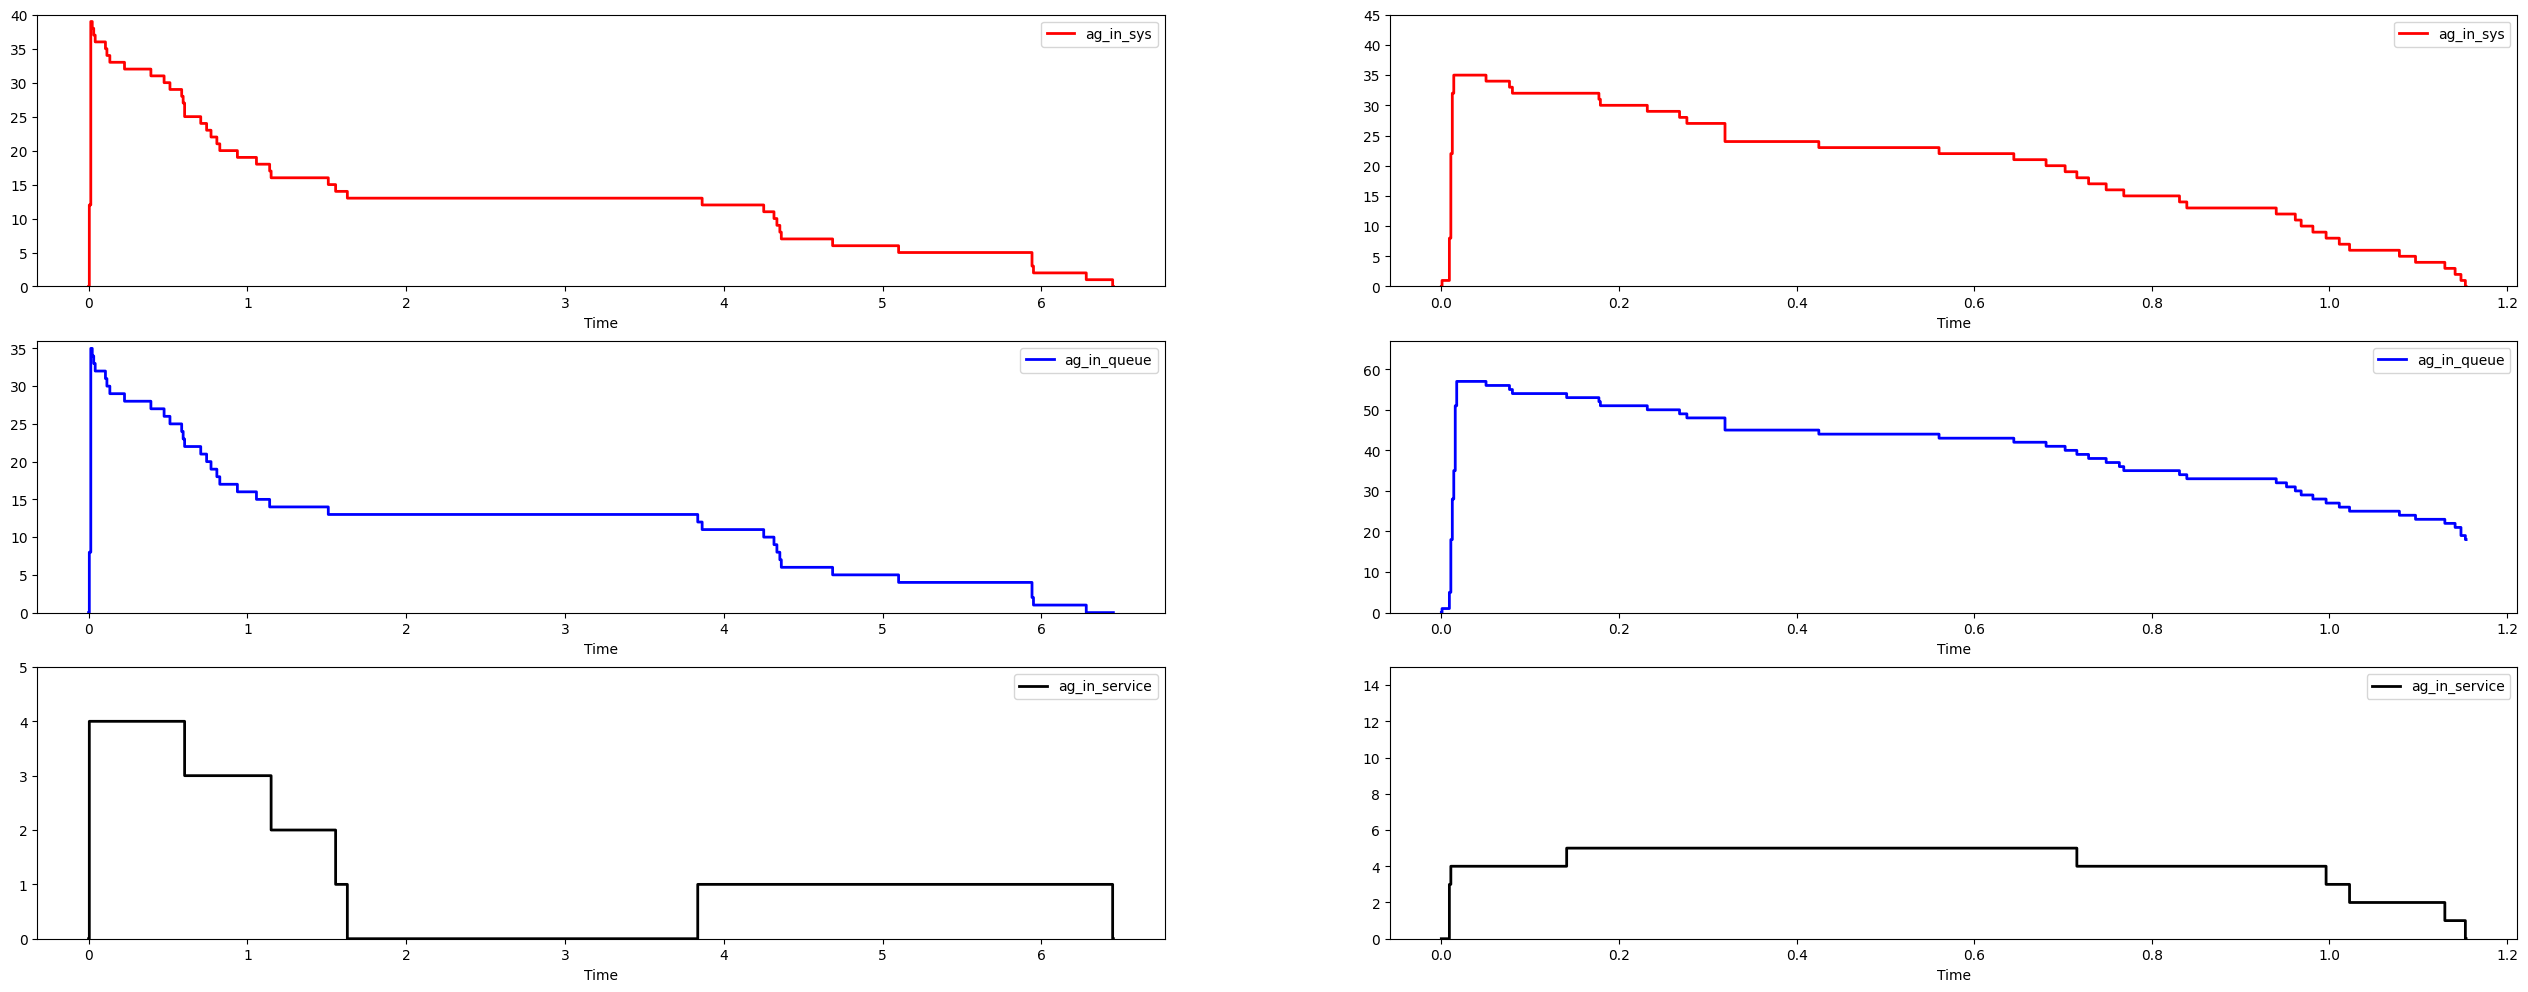

In [ ]:
run_graph(arval_intensity, srv_time, rng1, q_size, test_size)

                   run value
mean_sojourn_time   2.907645
mean_waiting_time    2.71378
max_waiting_time    8.867806
mean_service_time   0.193866
waiting_proportion  0.091429
blocked_proportion       0.0
servers_max_usage        0.0


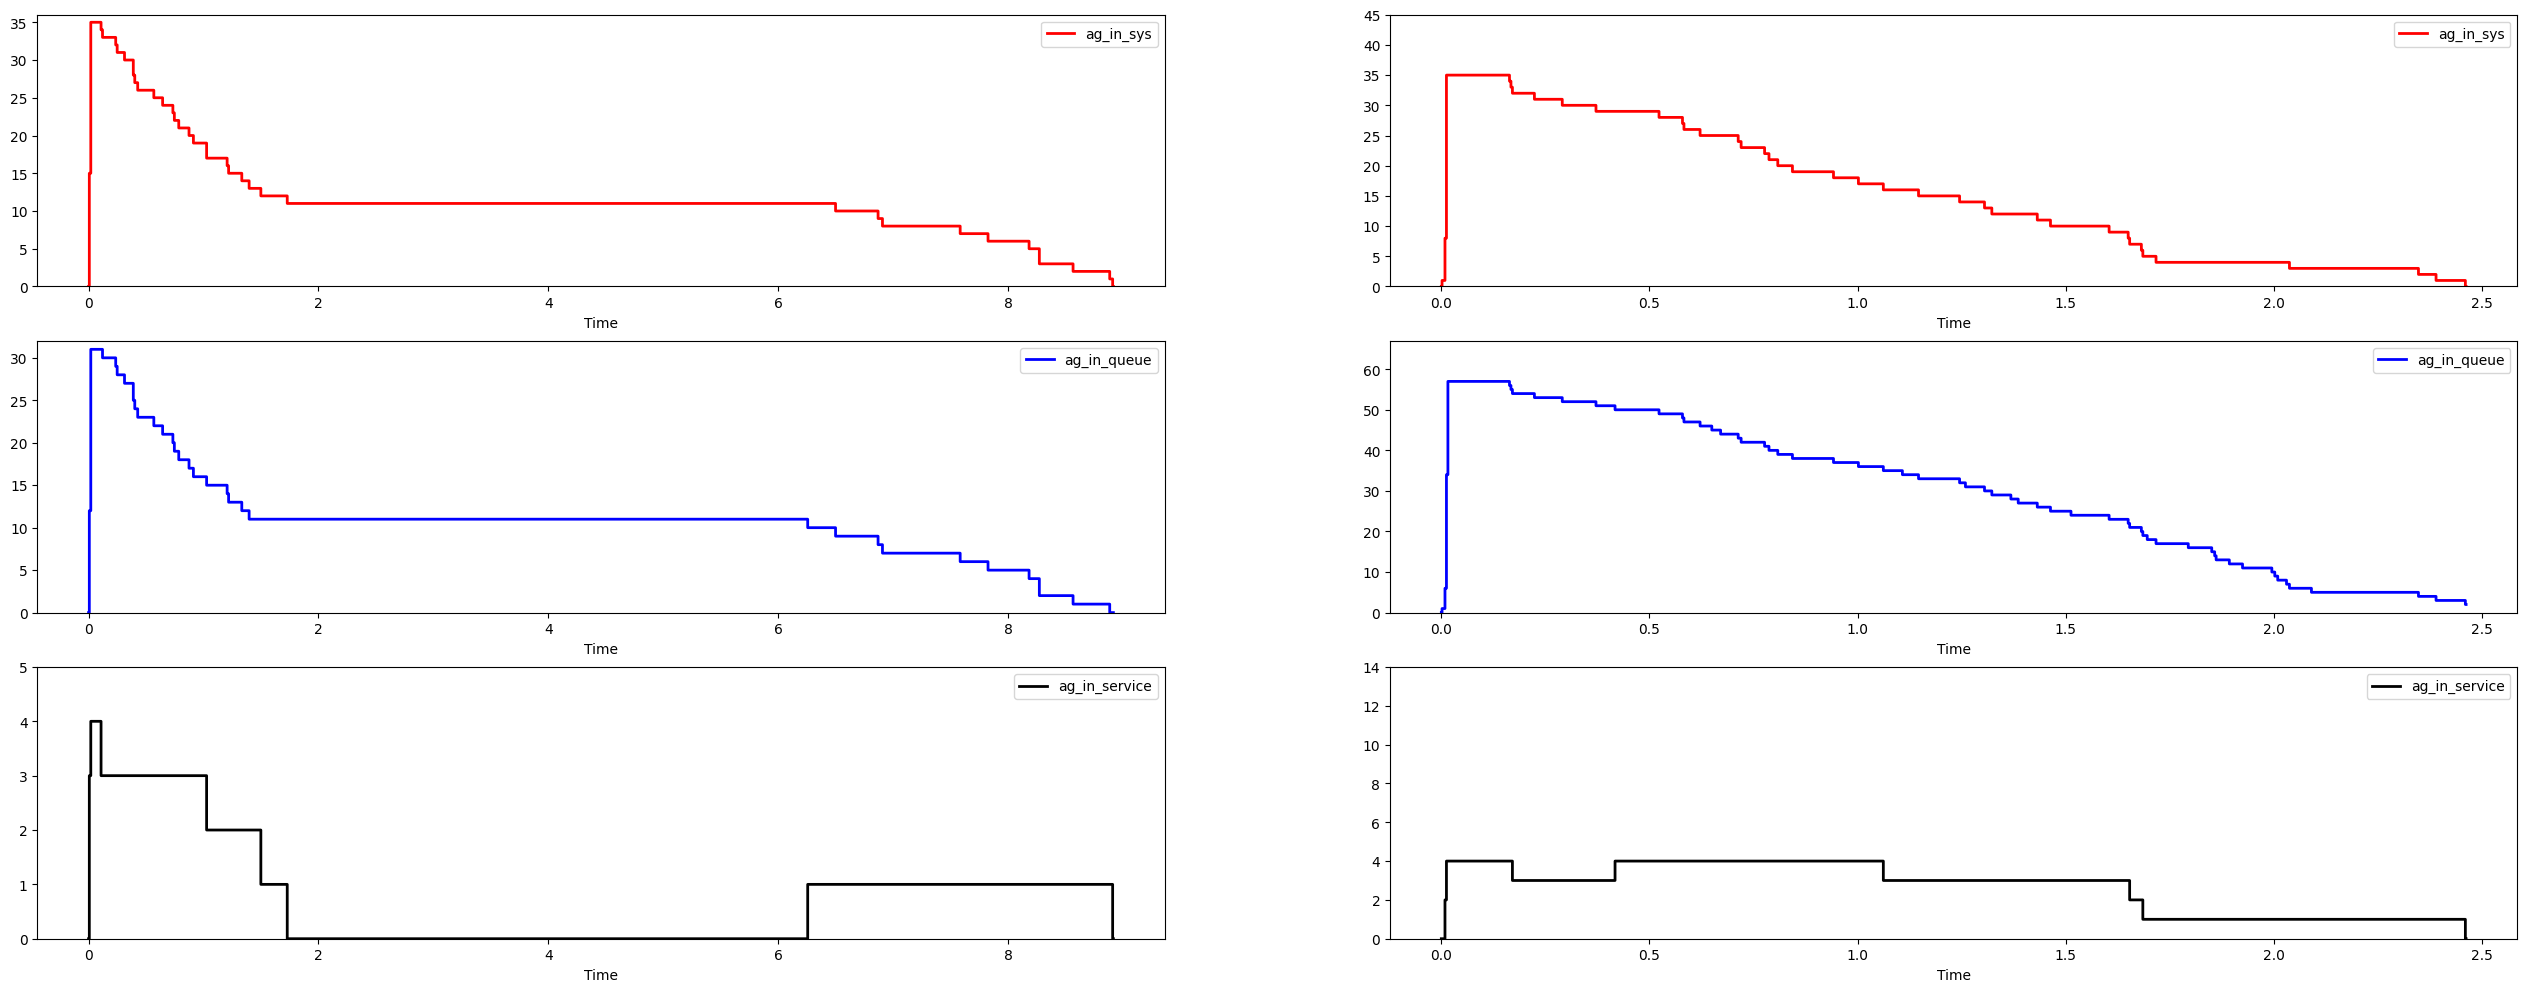

In [ ]:
run_graph(arval_intensity, srv_time, rng1, q_size, test_size)

                   run value
mean_sojourn_time   2.549904
mean_waiting_time   2.455596
max_waiting_time    9.369498
mean_service_time   0.094308
waiting_proportion  0.172727
blocked_proportion       0.0
servers_max_usage        0.0


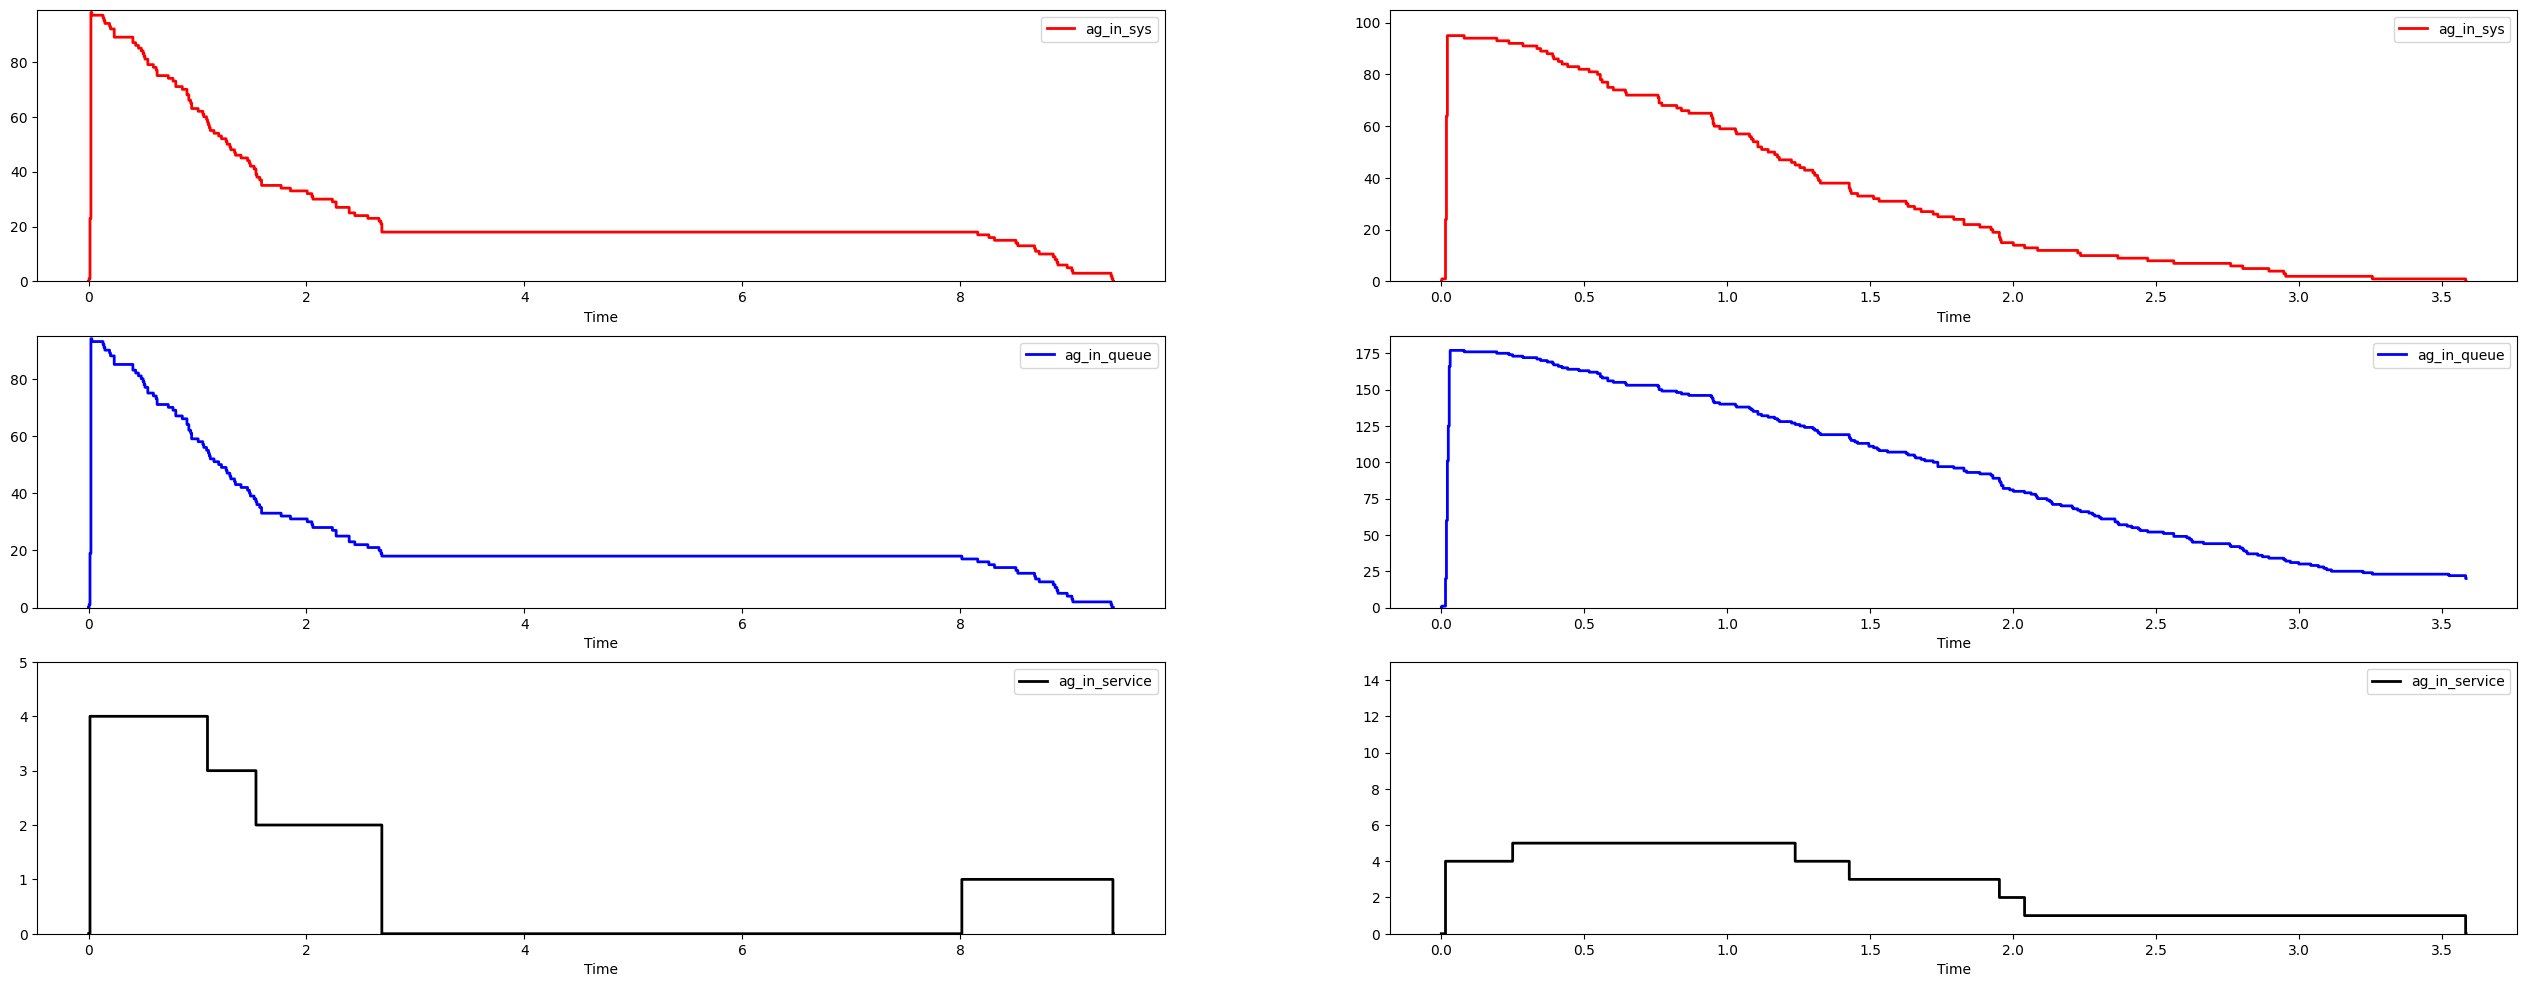

In [ ]:

test_size = [100,80,100,120,150]
q_size = [30,30,30]
srv_time = [1./15., 1./12., 1./10., 1./6., 1./2.]
arval_intensity = [1./50., 1./50., 1./50., 1./50., 1./50.]

run_graph(arval_intensity, srv_time, rng, q_size, test_size)

                   run value
mean_sojourn_time   2.780166
mean_waiting_time    2.68731
max_waiting_time    8.852333
mean_service_time   0.092857
waiting_proportion  0.178182
blocked_proportion       0.0
servers_max_usage        0.0


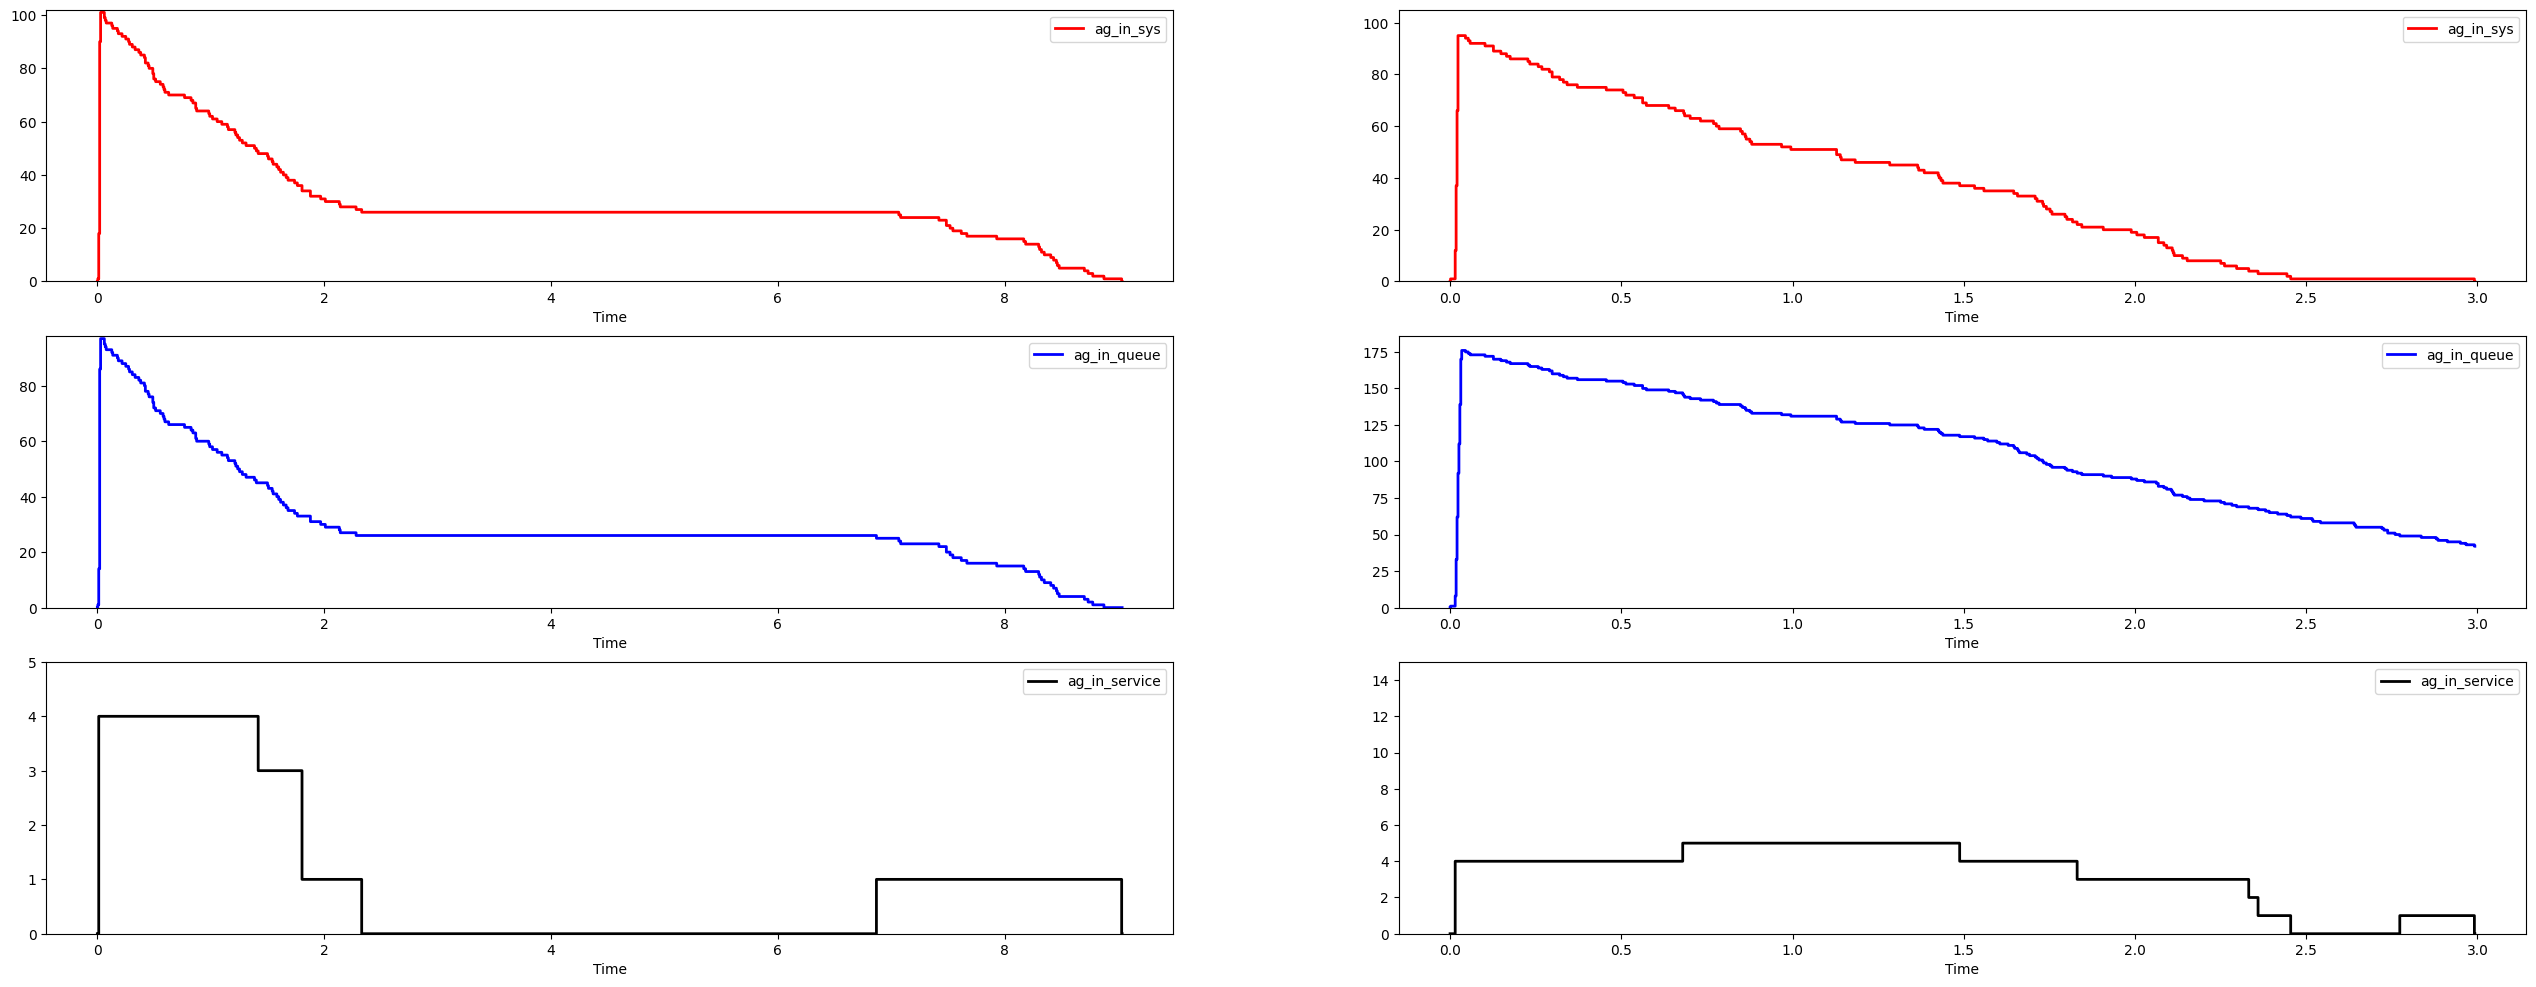

In [ ]:
run_graph(arval_intensity, srv_time, rng1, q_size, test_size)

                    run value
mean_sojourn_time     3.49151
mean_waiting_time    3.378421
max_waiting_time    12.153437
mean_service_time    0.113089
waiting_proportion   0.169091
blocked_proportion        0.0
servers_max_usage         0.0


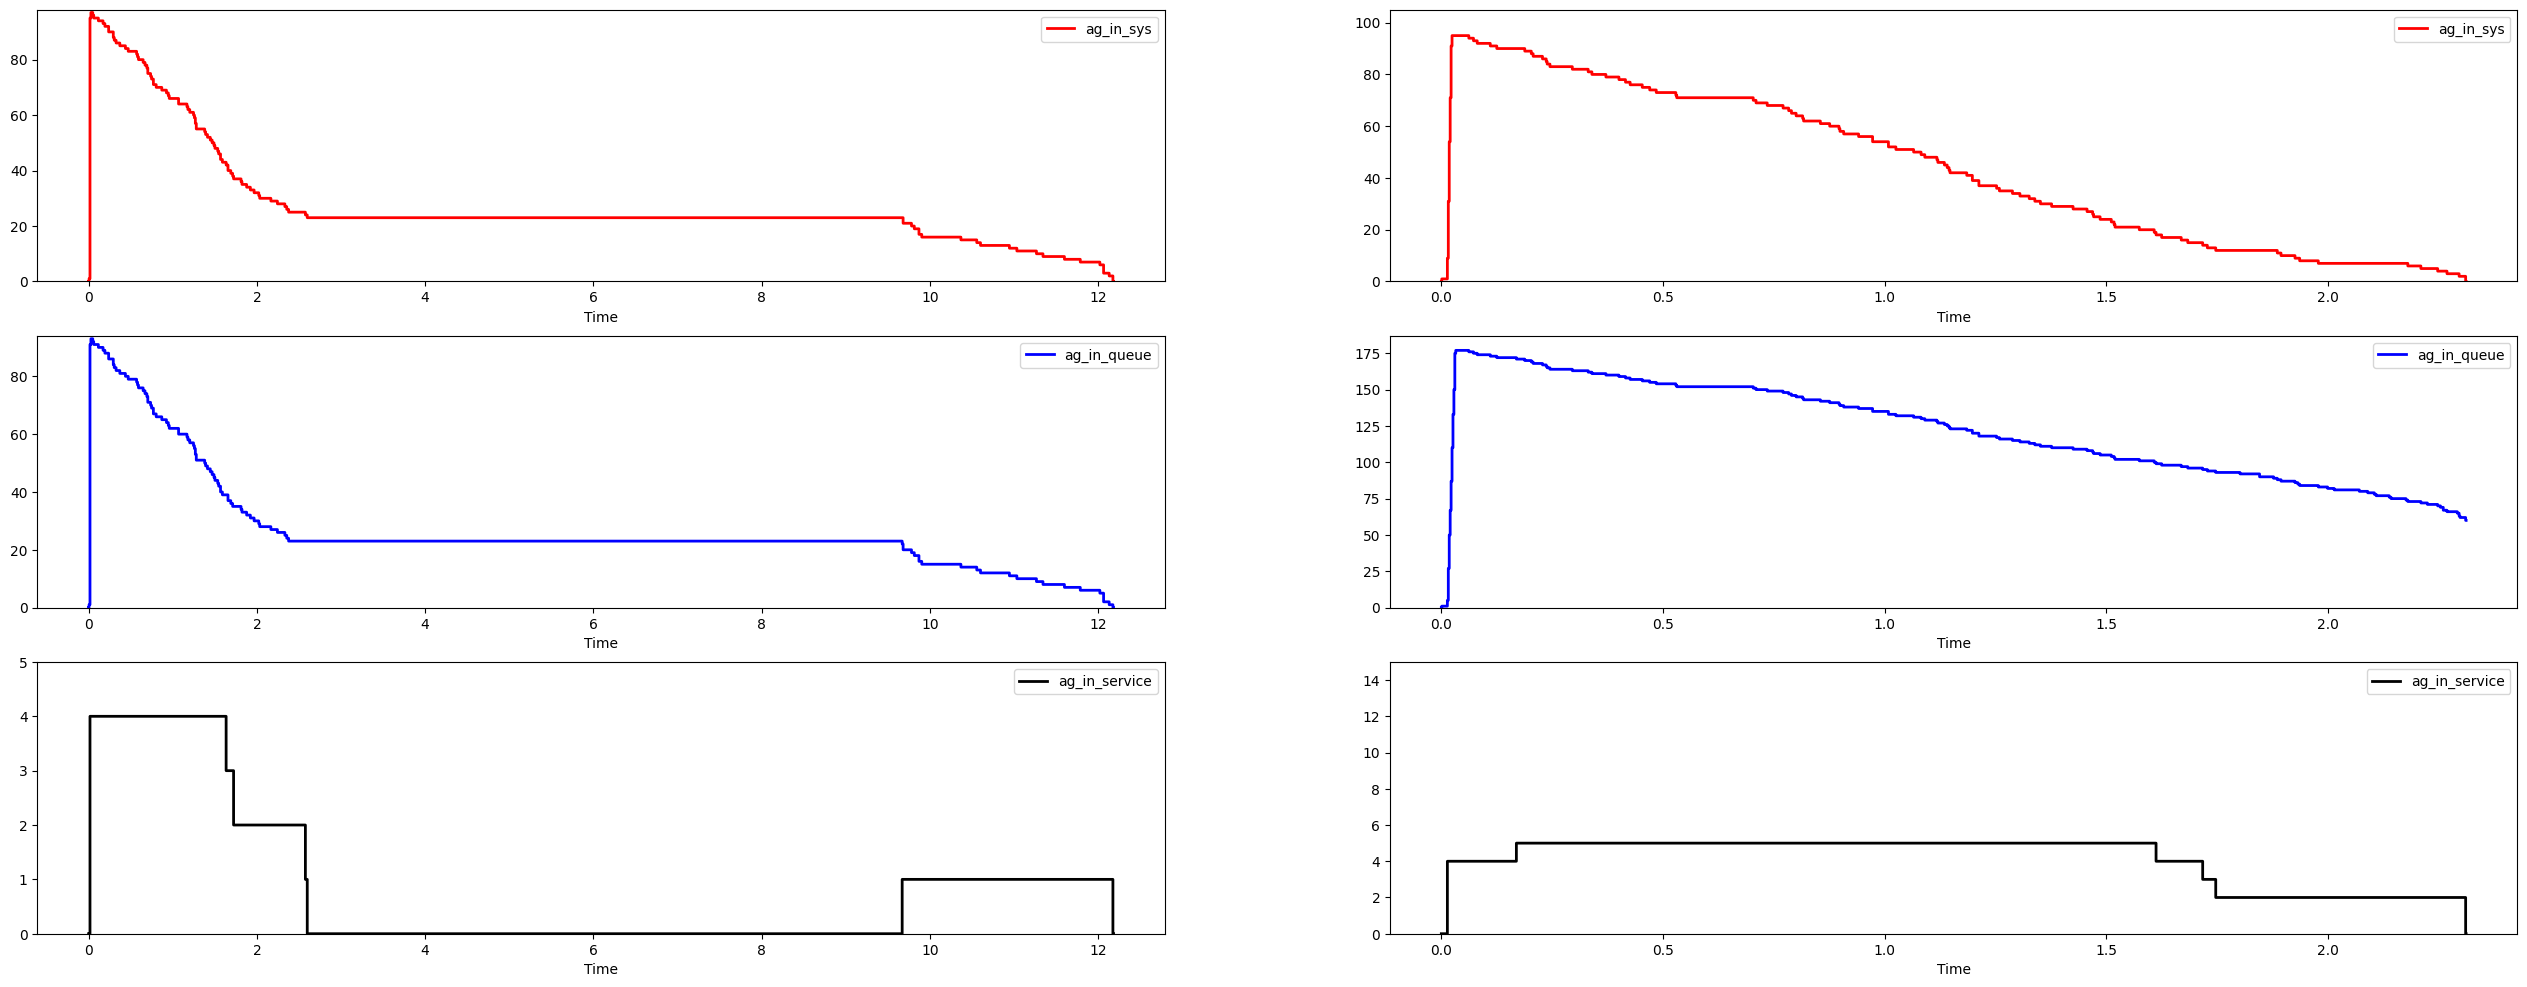

In [ ]:
run_graph(arval_intensity, srv_time, rng3, q_size, test_size)

                   run value
mean_sojourn_time   2.155446
mean_waiting_time   1.932413
max_waiting_time    6.939589
mean_service_time   0.223034
waiting_proportion      0.07
blocked_proportion       0.0
servers_max_usage        0.0


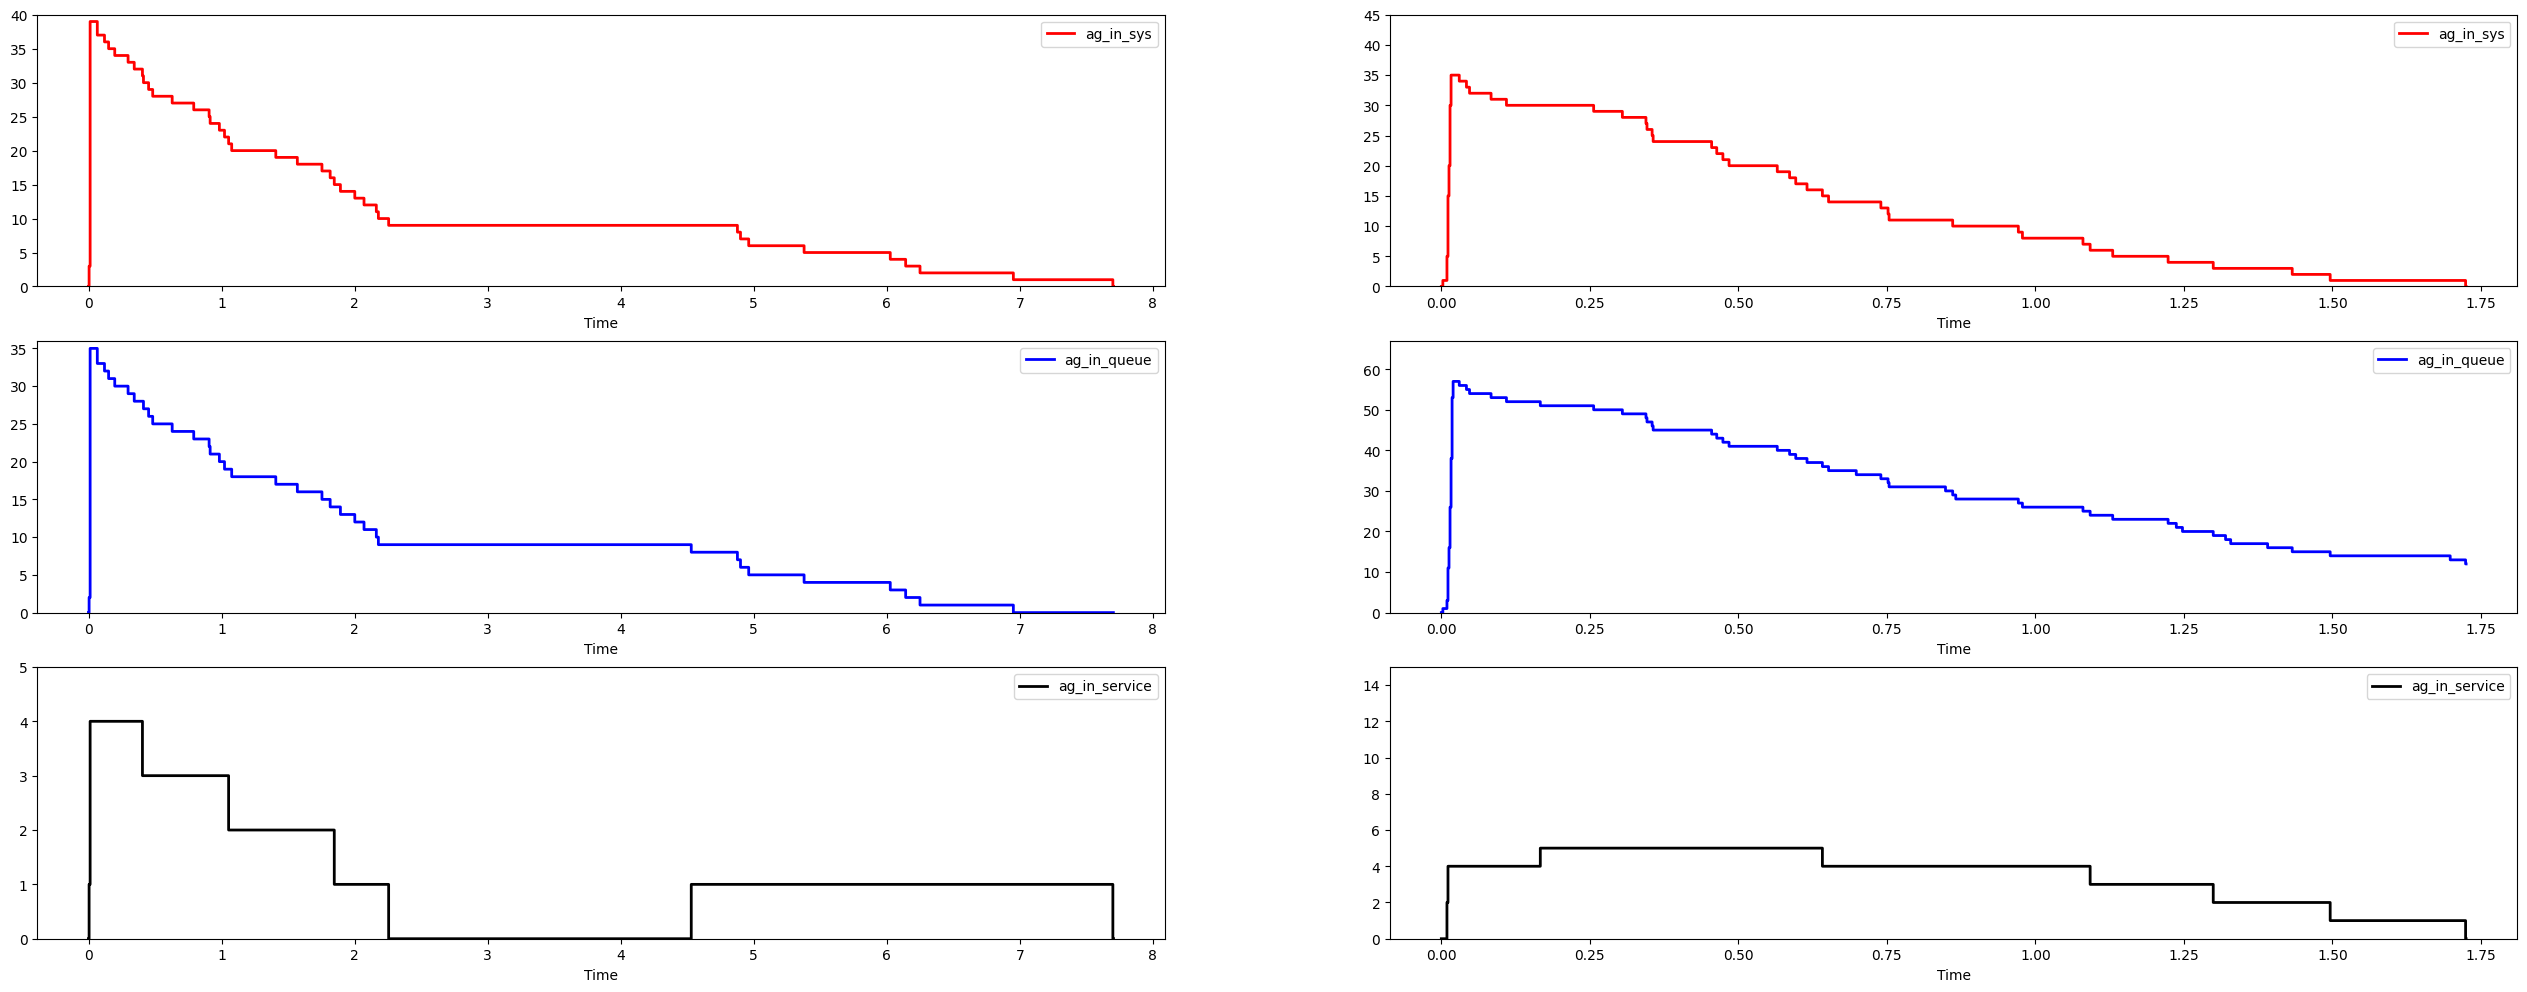

In [ ]:
test_size = [100,100,100,100,100]
q_size = [10,10,10]
srv_time = [1./6., 1./6., 1./6., 1./6., 1./6.]
arval_intensity = [1./40., 1./40., 1./40., 1./40., 1./40.]

run_graph(arval_intensity, srv_time, rng, q_size, test_size)

*CONCLUSION:*

Dans cette section 2.2, différentes architectures ont été utilisées pour les simulations de file d'attente. Les résultats montrent que quelle que soit l'architecture utilisée et les variables d'entrée, les courbes ont la même forme générale.

Cependant, il est intéressant de noter que plus la taille des simulations est grande, plus les courbes deviennent plates. Cela suggère que lorsque la taille des simulations est augmentée, les résultats tendent à se stabiliser et à se rapprocher d'un comportement prévisible.

Une observation importante est que les courbes LIFO (celles de Droite) sont toujours plus rapides à l'exécution que les courbes FIFO (celles de gauches). Cela peut être dû à la façon dont les agents sont traités dans la file d'attente.

**Réponse Q2.3**

Si l'on introduit une fonction de dissatisfaction des agents donnée par $b_1 + 2b_2 + \cdots + 5b_5$, où $b_i$ correspond au nombre d'agents de la population $A_i$ qui n'ont pas pu accéder au système, cela signifie que la satisfaction des agents dépend du nombre d'agents de chaque population qui n'ont pas pu être servis.

Pour tenir compte de cette fonction de dissatisfaction dans la comparaison des architectures, nous pouvons ajuster la manière dont nous calculons la métrique "Proportion d'agents bloqués". Au lieu de simplement considérer le nombre total d'agents bloqués, nous allons attribuer un poids à chaque population en fonction de $b_i$.

Voici comment nous pouvons modifier le code pour prendre en compte cette fonction de dissatisfaction :

1. Dans la classe MQS1, ajoutez un attribut dissatisfaction_weights pour stocker les poids de la fonction de dissatisfaction pour chaque population :
```py
self.dissatisfaction_weights = [1, 2, 3, 4, 5]  # Poids de la fonction de dissatisfaction
```
2. Modifiez la méthode posttreat() de la classe MQS1 pour calculer la satisfaction des agents en utilisant la fonction de dissatisfaction :
```py
def posttreat(self):
    tops = self.tops

    tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
    tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
    tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
    tops['blocked'] = tops['t_depart_sys'] == -1
    tops['waited'] = tops['t_waiting'] > 0

    # Calcul de la satisfaction des agents
    tops['satisfaction'] = tops.groupby('subpop')['blocked'].transform('sum')
    tops['satisfaction'] = tops['satisfaction'] * self.dissatisfaction_weights[tops['subpop']]
```
3. Modifiez la méthode timeline() de la classe MQS1 pour calculer la satisfaction globale des agents et l'ajouter aux statistiques :
```py
def timeline(self, t_delation=2):
    tops = self.tops
    total_size = self.total_size

    t_range = np.linspace(0., tops['t_depart_sys'].max(), int(t_delation * total_size))
    process = pd.DataFrame(np.empty((len(t_range), 4), dtype=object), index=t_range,
                           columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'subpop'])

    for t in process.index:
        process.loc[t, 'ag_in_sys'] = ((tops['t_arval_queue'] <= t) & (tops['t_depart_sys'] > t)).sum()
        process.loc[t, 'ag_in_queue'] = ((tops['t_arval_queue'] <= t) & (tops['t_arval_srv'] > t)).sum()
        process.loc[t, 'ag_in_service'] = ((tops['t_arval_srv'] < t) & (tops['t_depart_sys'] > t)).sum()

    stats = pd.DataFrame(index=['mean_sojourn_time', 'mean_waiting_time', 'max_waiting_time', 'mean_service_time',
                                'waiting_proportion', 'blocked_proportion', 'servers_max_usage', 'agent_satisfaction'], columns=['run value'])
    stats.loc['mean_sojourn_time'] = tops.loc[~tops['blocked'], 't_sojourn'].mean()
    stats.loc['mean_waiting_time'] = tops.loc[~tops['blocked'], 't_waiting'].mean()
    stats.loc['max_waiting_time'] = tops['t_waiting'].max()
    stats.loc['mean_service_time'] = tops.loc[~tops['blocked'], 't_service'].mean()
    stats.loc['waiting_proportion'] = tops.loc[~tops['blocked'], 'waited'].mean()
    stats.loc['blocked_proportion'] = tops['blocked'].mean()
    stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.srv_z).mean()
    stats.loc['agent_satisfaction'] = tops['satisfaction'].sum() / total_size

    return process, stats
```
4. Dans la partie où nous exécutons les simulations et comparons les résultats, ajoutez la métrique de satisfaction des agents pour chaque architecture : 
```py
# Exécution des simulations pour chaque architecture
stats_arch1 = run_simulation(arval_intensity_arch1, srv_time_arch1, queue_size_arch1)
stats_arch2 = run_simulation(arval_intensity_arch2, srv_time_arch2, queue_size_arch2)
stats_arch3 = run_simulation(arval_intensity_arch3, srv_time_arch3, queue_size_arch3)

# Affichage des résultats
print("Architecture 1:")
print(stats_arch1)
print("\nArchitecture 2:")
print(stats_arch2)
print("\nArchitecture 3:")
print(stats_arch3)
```


Avec ces modifications, nous avons ajouté la métrique "Satisfaction des agents" qui prend en compte la fonction de dissatisfaction basée sur le nombre d'agents de chaque population qui n'ont pas pu accéder au système.